# Labs Access Analysis: 05 Population Analysis with Facebook Data

## Setup

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import os
import gc
from matplotlib.patches import Patch

# Change the font
sns.set_context("poster", font_scale=1.5)
sns.set_style(style="whitegrid")
matplotlib.rc('font', family='serif', serif='Fira Sans')

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Load data, csv
data_csv = pd.read_csv('data/valid_labs.csv')
data_csv['Lat'] = data_csv['Lat'].astype(float)
data_csv['Long'] = data_csv['Long'].astype(float)
data_csv = data_csv[(((~data_csv.Lat.isnull()) & (~data_csv.Long.isnull())))]

In [3]:
data_labs = gpd.GeoDataFrame(
    data_csv,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(data_csv.Long, data_csv.Lat))

In [4]:
data_labs.head()

,Unnamed: 0,Name,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,geometry
0,0,Fab Lab Barcelona,Fab Lab,Barcelona,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692)
1,1,MADE Makerspace Barcelona,Fab Lab,Barcelona,BCN,Carrer Noguera Pallaresa 59-61,8014.0,41.373238,2.141084,"Fablabs.io, Hackerspaces.org, Makerspaces.make.co",NaN,NaN,POINT (2.14108 41.37324)
2,2,Soko Tech,Fab Lab,Barcelona,BCN,"Carrer de Vallès i Ribot, 36",8027.0,41.424535,2.188883,Fablabs.io,https://soko.tech/,NaN,POINT (2.18888 41.42454)
3,3,LSCongres,Fab Lab,Barcelona,BCN,"Carrer del Cardenal Tedeschini, 50",8027.0,41.426002,2.182026,Fablabs.io,https://fablabs.io/labs/lscongres,NaN,POINT (2.18203 41.42600)
4,4,Green Fab Lab,Fab Lab,Cerdanyola del Vallès,BCN,"Ctra. BV-1415 (Horta-Cerdanyola), km 7",8290.0,41.450394,2.133441,Fablabs.io,NaN,NaN,POINT (2.13344 41.45039)


In [5]:
data_labs.set_index('Unnamed: 0', inplace=True)
data_labs.index.names = ['']

In [6]:
data_labs.explore()

In [7]:
isochrones = pd.read_json("data/isochrones.json")

In [8]:
isochrones.head()

,type,bbox,features,metadata,name
0,FeatureCollection,"[2.181814, 41.386685, 2.206919, 41.408001]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Fab Lab Barcelona
1,FeatureCollection,"[2.127469, 41.362337, 2.156052, 41.384602]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,MADE Makerspace Barcelona
2,FeatureCollection,"[2.174851, 41.412242, 2.201856, 41.435695]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Soko Tech
3,FeatureCollection,"[2.167014, 41.414324, 2.195139, 41.437322]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,LSCongres
4,FeatureCollection,"[2.130189, 41.443331, 2.143093, 41.453097]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Green Fab Lab


## Transform data for geodataframe

In [9]:
isochrones['longitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][0])
isochrones['latitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][1])
isochrones['area_units'] = isochrones['metadata'].apply(lambda x: x['query']['area_units'])

In [10]:
isochrones['total_pop'] = isochrones['features'].apply(lambda x: x[0]['properties']['total_pop'])
isochrones['area'] = isochrones['features'].apply(lambda x:x[0]['properties']['area'])
isochrones['reachfactor'] = isochrones['features'].apply(lambda x: x[0]['properties']['reachfactor'])

In [11]:
isochrones['coordinates'] = isochrones['features'].apply(lambda x: x[0]['geometry']['coordinates'])
isochrones['geometry_type'] = isochrones['features'].apply(lambda x: x[0]['geometry']['type'])

In [12]:
isochrones['geometry'] = isochrones['coordinates'].apply(lambda x: Polygon(x[0]))

In [13]:
isochrones = isochrones[['name','longitude','latitude','total_pop','area','reachfactor','geometry']]

In [14]:
isochrones = gpd.GeoDataFrame(
    isochrones,
    geometry=isochrones.geometry,
    crs='EPSG:4326')

In [15]:
isochrones.explore()

In [16]:
isochrones.head()

,name,longitude,latitude,total_pop,area,reachfactor,geometry
0,Fab Lab Barcelona,2.194335,41.396925,84175.0,4351089.58,0.8864,"POLYGON ((2.18181 41.39619, 2.18182 41.39463, ..."
1,MADE Makerspace Barcelona,2.141084,41.373238,88686.0,4388156.04,0.8939,"POLYGON ((2.12747 41.37483, 2.12830 41.37021, ..."
2,Soko Tech,2.188883,41.424535,90167.0,4342469.36,0.8846,"POLYGON ((2.17485 41.42471, 2.17489 41.42377, ..."
3,LSCongres,2.182026,41.426002,95371.0,4470900.19,0.9108,"POLYGON ((2.16701 41.42773, 2.16735 41.42654, ..."
4,Green Fab Lab,2.133441,41.450394,29.0,668382.48,0.1362,"POLYGON ((2.13019 41.44688, 2.13044 41.44663, ..."


In [17]:
isochrones.to_file("data/lab_isochrones.geojson",driver='GeoJSON')

In [18]:
columns = {
    'name': 'Name'
}
isochrones.rename(columns=columns, inplace=True)

In [19]:
labs = isochrones.merge(data_labs, on="Name")
labs = gpd.GeoDataFrame(labs)

In [20]:
columns = {
    'geometry_x': 'geometry'
}
labs.rename(columns=columns, inplace=True)

In [21]:
labs.head()

,Name,longitude,latitude,total_pop,area,reachfactor,geometry,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,geometry_y
0,Fab Lab Barcelona,2.194335,41.396925,84175.0,4351089.58,0.8864,"POLYGON ((2.18181 41.39619, 2.18182 41.39463, ...",Fab Lab,Barcelona,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692)
1,MADE Makerspace Barcelona,2.141084,41.373238,88686.0,4388156.04,0.8939,"POLYGON ((2.12747 41.37483, 2.12830 41.37021, ...",Fab Lab,Barcelona,BCN,Carrer Noguera Pallaresa 59-61,8014.0,41.373238,2.141084,"Fablabs.io, Hackerspaces.org, Makerspaces.make.co",NaN,NaN,POINT (2.14108 41.37324)
2,Soko Tech,2.188883,41.424535,90167.0,4342469.36,0.8846,"POLYGON ((2.17485 41.42471, 2.17489 41.42377, ...",Fab Lab,Barcelona,BCN,"Carrer de Vallès i Ribot, 36",8027.0,41.424535,2.188883,Fablabs.io,https://soko.tech/,NaN,POINT (2.18888 41.42454)
3,LSCongres,2.182026,41.426002,95371.0,4470900.19,0.9108,"POLYGON ((2.16701 41.42773, 2.16735 41.42654, ...",Fab Lab,Barcelona,BCN,"Carrer del Cardenal Tedeschini, 50",8027.0,41.426002,2.182026,Fablabs.io,https://fablabs.io/labs/lscongres,NaN,POINT (2.18203 41.42600)
4,Green Fab Lab,2.133441,41.450394,29.0,668382.48,0.1362,"POLYGON ((2.13019 41.44688, 2.13044 41.44663, ...",Fab Lab,Cerdanyola del Vallès,BCN,"Ctra. BV-1415 (Horta-Cerdanyola), km 7",8290.0,41.450394,2.133441,Fablabs.io,NaN,NaN,POINT (2.13344 41.45039)


In [22]:
columns = {
    'Name': 'name',
    'Type': 'type',
    'City': 'city',
    'Cluster':  'cluster',
    'Address': 'address',
    'CAP': 'zipcode',
    'Source': 'source',
    'URL': 'url',
    'Notes': 'notes',
    'geomtry_y': 'geomtry'
}
labs.rename(columns=columns, inplace=True)

In [23]:
#labs.to_file("data/labs_isochrones.geojson",driver='GeoJSON')

# Analysis of Facebook data

## Setup and functions

In [24]:
labs_ita = labs[labs.cluster == "MI"]
labs_esp = labs[labs.cluster == "BCN"]
labs_ita = gpd.GeoDataFrame(labs_ita)
labs_esp = gpd.GeoDataFrame(labs_esp)

In [25]:
labs_ita.head(3)

,name,longitude,latitude,total_pop,area,reachfactor,geometry,type,city,cluster,address,zipcode,Lat,Long,source,url,notes,geometry_y
7,The FabLab: Make in Milano,9.207913,45.444046,41892.0,3820144.23,0.7782,"POLYGON ((9.19176 45.44332, 9.19177 45.44302, ...",Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,NaN,NaN,POINT (9.20791 45.44405)
8,Vectorealism FabLab,9.231811,45.438305,25436.0,2801791.89,0.5708,"POLYGON ((9.21727 45.44017, 9.21755 45.43716, ...",Service,Milan,MI,"Via Carlo Boncompagni, 57",20139.0,45.438305,9.231811,Fablabs.io,https://fablabs.io/labs/vectorealismfablab,NaN,POINT (9.23181 45.43830)
9,DamASpace,9.179818,45.452457,57939.0,4758037.48,0.9693,"POLYGON ((9.16402 45.45121, 9.16478 45.44769, ...",Fab Lab,Milan,MI,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,Fablabs.io,https://fablabs.io/labs/DamASpaceFablab,NaN,POINT (9.17982 45.45246)


In [26]:
def getgeodataframearea(points,x,y):
    global isochrones
    env = env = isochrones.envelope.unary_union.bounds
    area = points[(points[x] >= env[0]) & (points[x] <= env[2]) & (points[y] >= env[1]) & (points[y] <= env[3])]
    geodataframe = gpd.GeoDataFrame(
        points,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(points[x], points[y]))
    return geodataframe

In [32]:
def adddatafromfile(data, file, column, datacolumn, coordcolname, tab):
    if tab:
        new_data = pd.read_csv(file, sep='\t')
    else:
        new_data = pd.read_csv(file)
    if coordcolname == "LatLon":
        new_data.rename({'Lon': 'longitude', 'Lat': 'latitude', 'Population': 'population'}, axis=1, inplace=True)
    else:
        new_data.rename({datacolumn: 'population'}, axis=1, inplace=True)
    points_cluster = getgeodataframearea(new_data,x='longitude',y='latitude')
    # save memory - destroy dataframe unused
    # del [[isochrones,ita_population,ita_15_24]]
    del [[new_data]]
    gc.collect()
    isochrones=pd.DataFrame()
    new_data=pd.DataFrame()
    sjoin_lab_points = points_cluster.sjoin(data, how='inner')
    data[column] = data.name.apply(lambda x: round(sjoin_lab_points[sjoin_lab_points.name == x].population.sum()))
    return

## Add data for Italy

In [33]:
adddatafromfile(data=labs_ita, file="data/hdx/population_ita_2019-07-01.csv", column='total', datacolumn="Population", coordcolname="LatLon", tab=False)

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [34]:
adddatafromfile(data=labs_ita, file="data/hdx/ITA_men_2019-08-03.csv", column='men', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [35]:
adddatafromfile(data=labs_ita, file="data/hdx/ITA_women_2019-08-03.csv", column='women', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


## Add data for Spain

In [36]:
adddatafromfile(data=labs_esp, file="data/hdx/esp_general_2020.csv", column='total', datacolumn="esp_general_2020", coordcolname="LatitudeLongitude", tab=False)

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [37]:
adddatafromfile(data=labs_esp, file="data/hdx/esp_men_2020.csv", column='men', datacolumn="esp_men_2020", coordcolname="LatitudeLongitude", tab=False)

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [38]:
adddatafromfile(data=labs_esp, file="data/hdx/esp_women_2020.csv", column='women', datacolumn="esp_women_2020", coordcolname="LatitudeLongitude", tab=False)

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


## Plot data

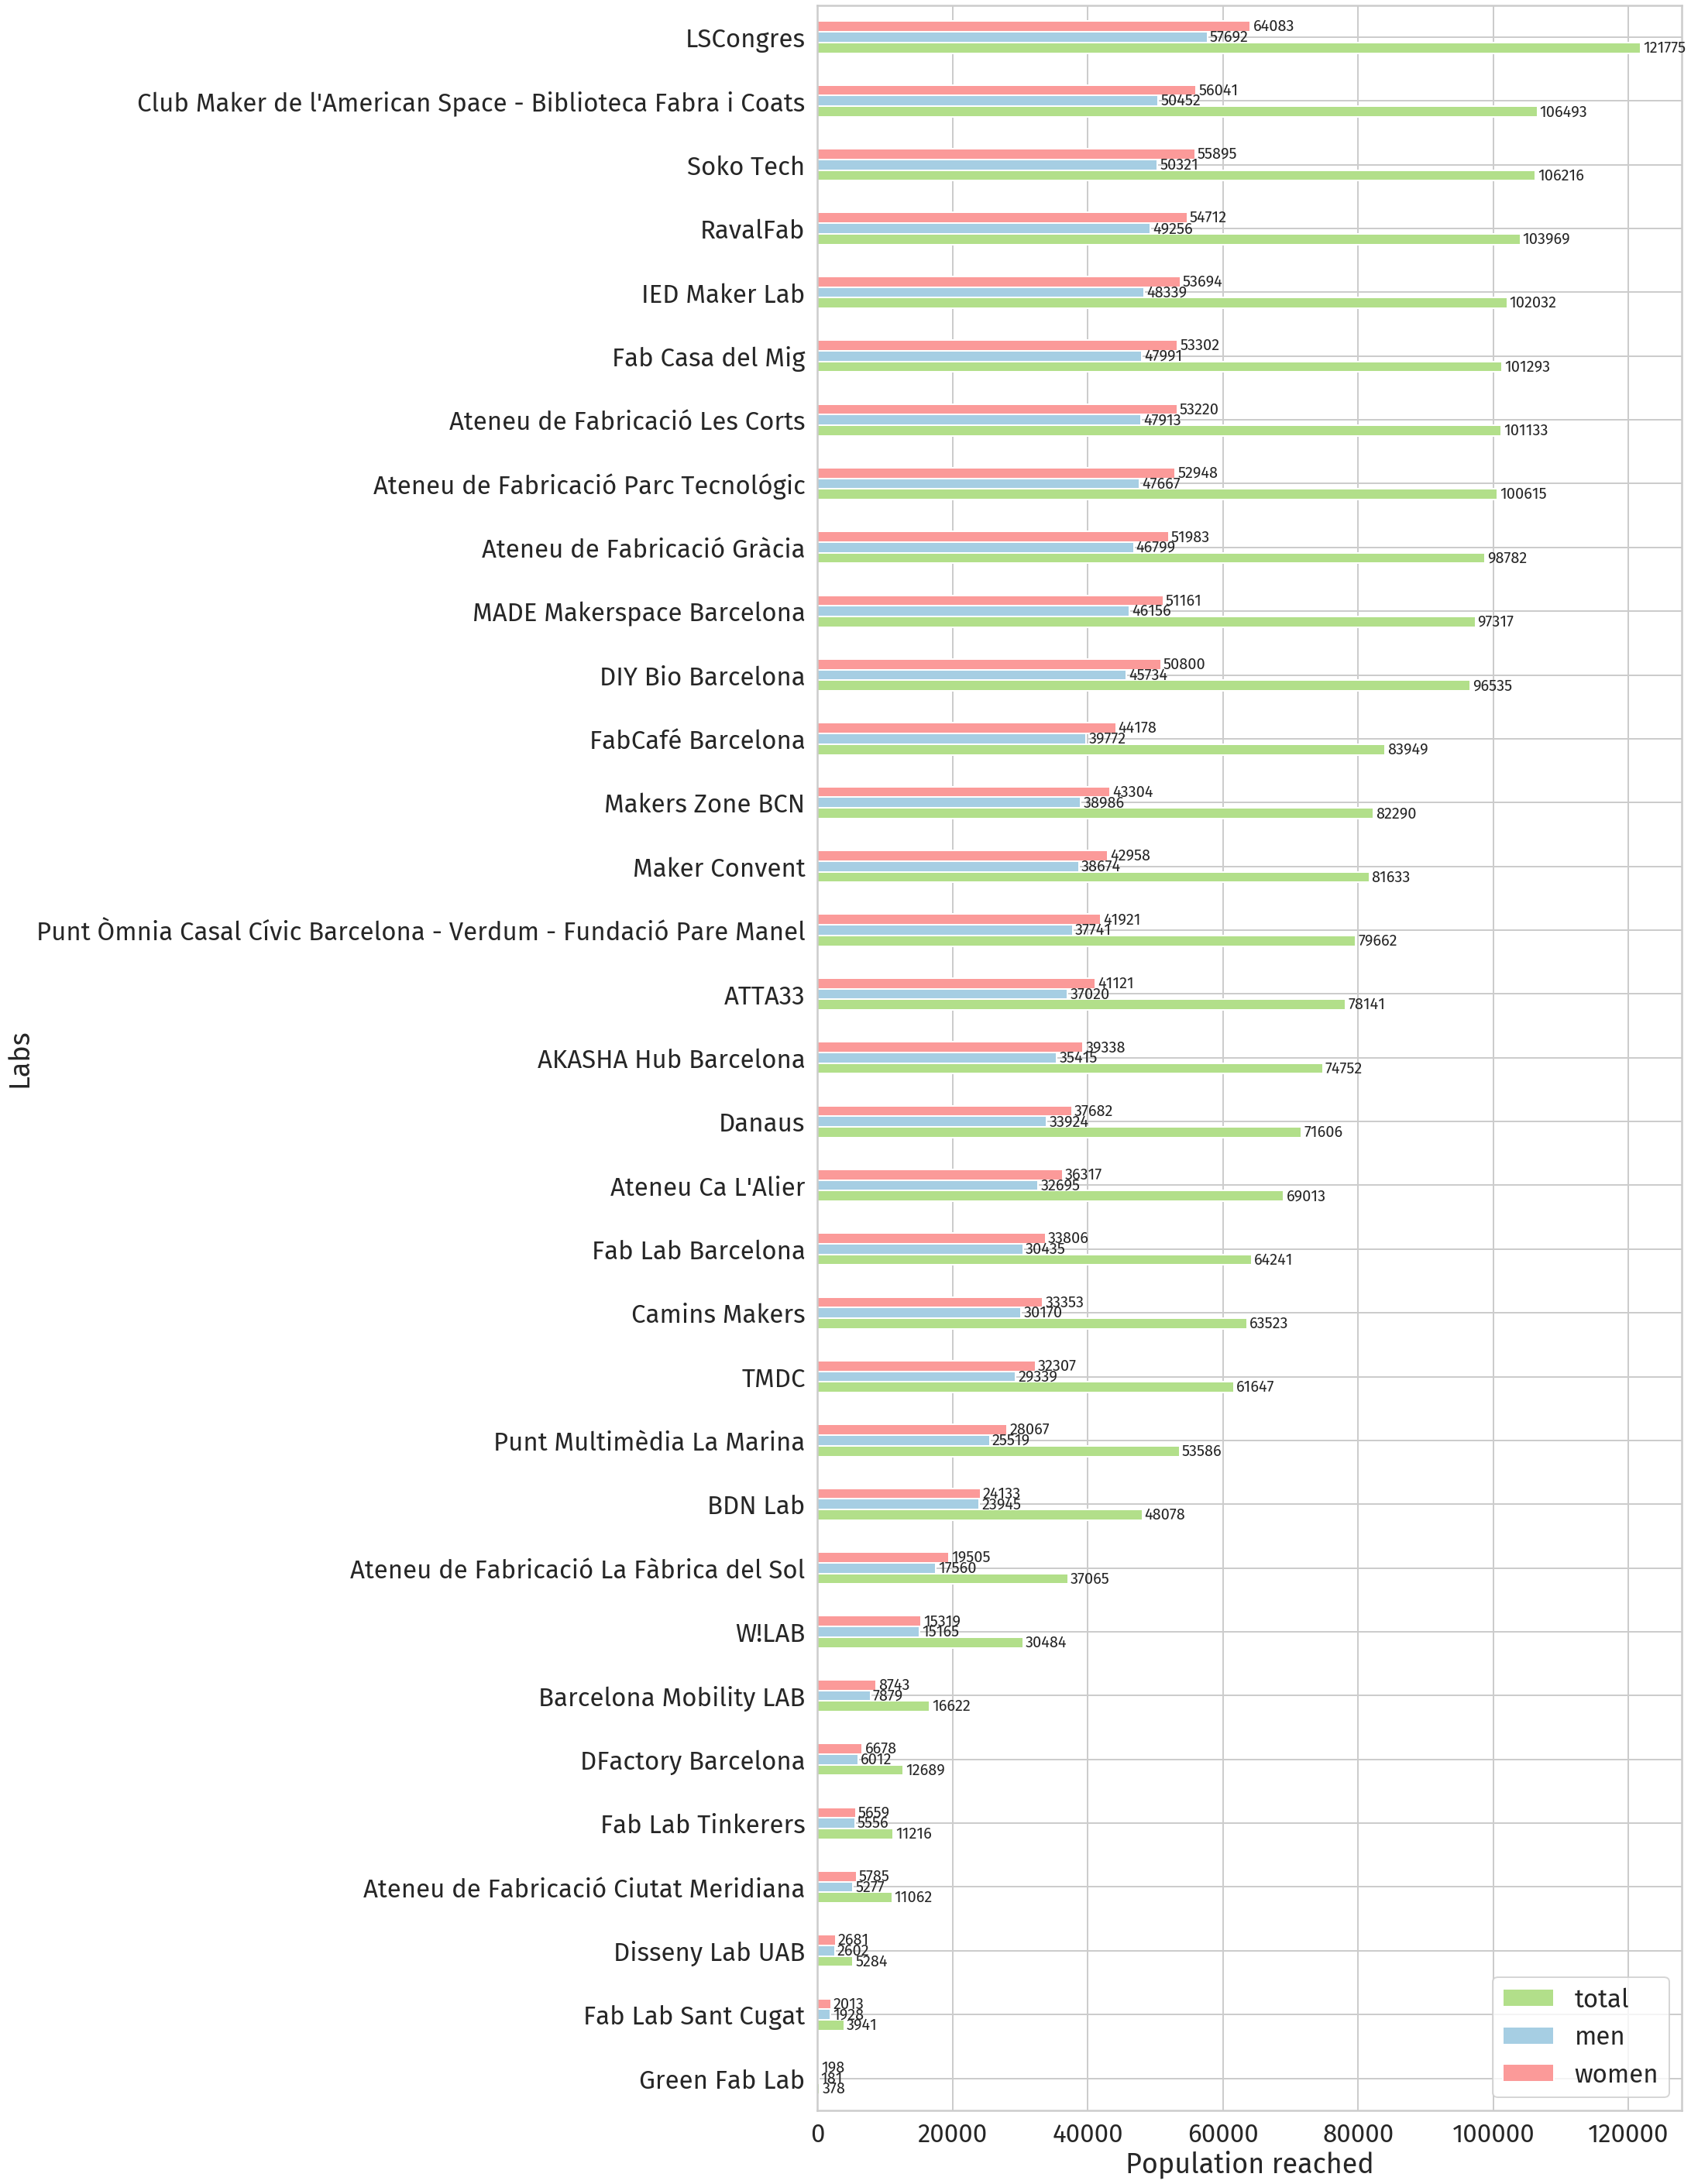

In [45]:
# Plot the data
colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
ax = labs_esp.set_index("name").sort_values(by=["total"])[["total", "men", "women"]].plot(kind="barh", color=colors, figsize=(20,50))
ax.bar_label(ax.containers[0], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[1], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[2], fmt="%d", size=20, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg/labs_esp_fbpop_tot.svg", bbox_inches="tight")
plt.savefig("png/labs_esp_fbpop_tot.png", dpi=300, bbox_inches="tight")

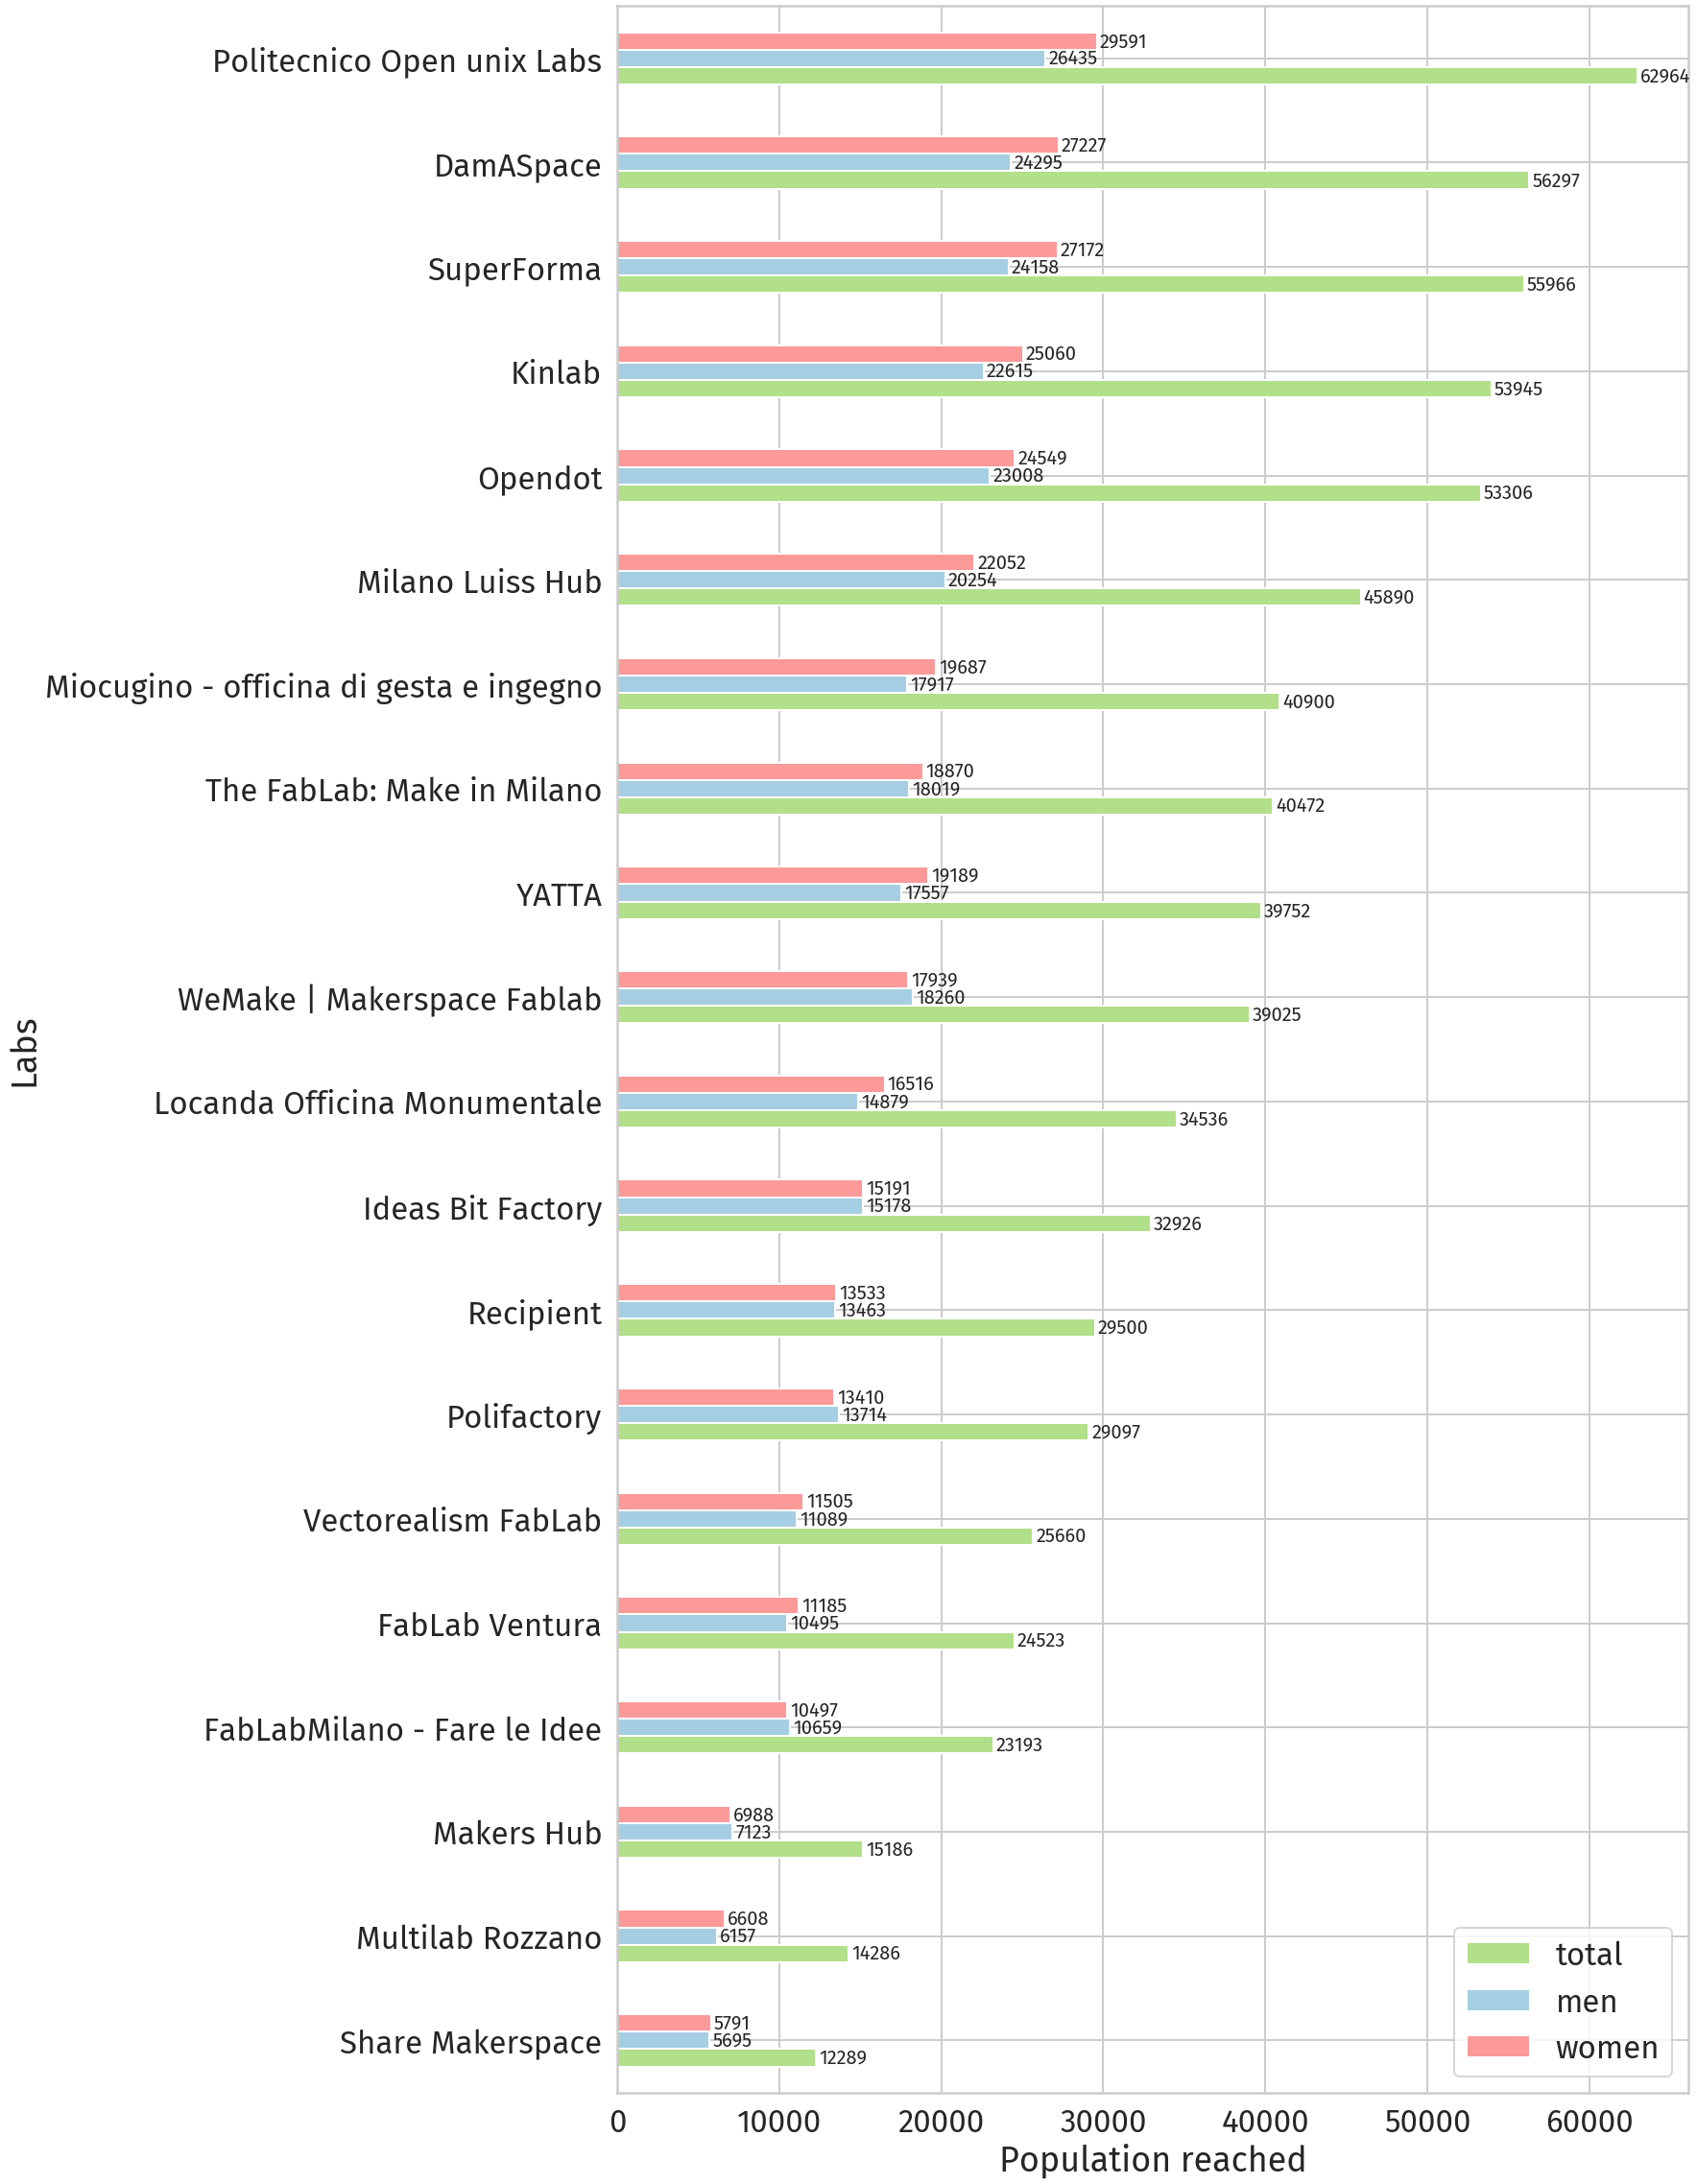

In [46]:
# Plot the data
colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
ax = labs_ita.set_index("name").sort_values(by=["total"])[["total", "men", "women"]].plot(kind="barh", color=colors, figsize=(20,40))
ax.bar_label(ax.containers[0], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[1], fmt="%d", size=20, padding=3)
ax.bar_label(ax.containers[2], fmt="%d", size=20, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg/labs_ita_fbpop_tot.svg", bbox_inches="tight")
plt.savefig("png/labs_ita_fbpop_tot.png", dpi=300, bbox_inches="tight")